In [1]:
import json, os, pathlib as p
import nibabel as nib
import numpy as np

from preprocessing import create_LR_img, scale_to_reference_img, pad_to_shape, extract_3D_patches, reconstruct_from_patches

#Find data
DATA_DIR = p.Path.home()/"data"/"bobsrepository"
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))

#Create T2 LR images
hr_t2 = nib.load(t2_files[0])
hr_t2_data = hr_t2.get_fdata()
lr_t2_data = create_LR_img(hr_t2_data, scale_factor=2)
lr_t2 = nib.Nifti1Image(lr_t2_data, hr_t2.affine)

#Scale to reference image
ref_img = nib.load(t1_files[0])
lr_t2 = scale_to_reference_img(lr_t2, ref_img)


In [2]:
#create zero padded image to fit model input size
padded_lr_t2, new_affine = pad_to_shape(lr_t2.get_fdata(), (192, 224 , 192), lr_t2.affine)
padded_lr_t2_img = nib.Nifti1Image(padded_lr_t2, new_affine)


Extracted 150 patches of size (64, 64, 64) from image of shape (192, 224, 192) with stride (32, 32, 32).


<OrthoSlicer3D: (192, 224, 192)>

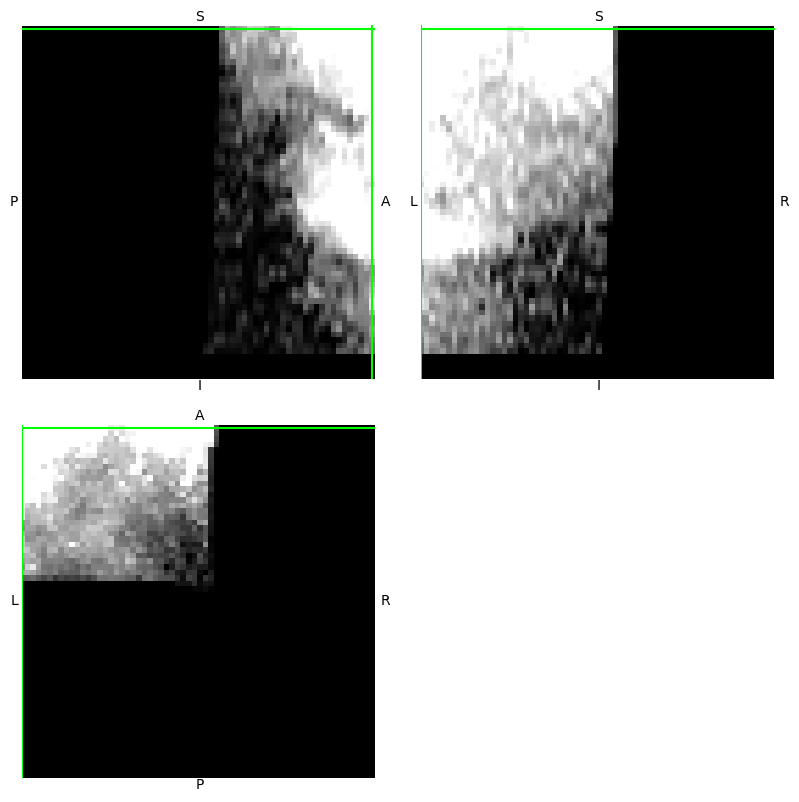

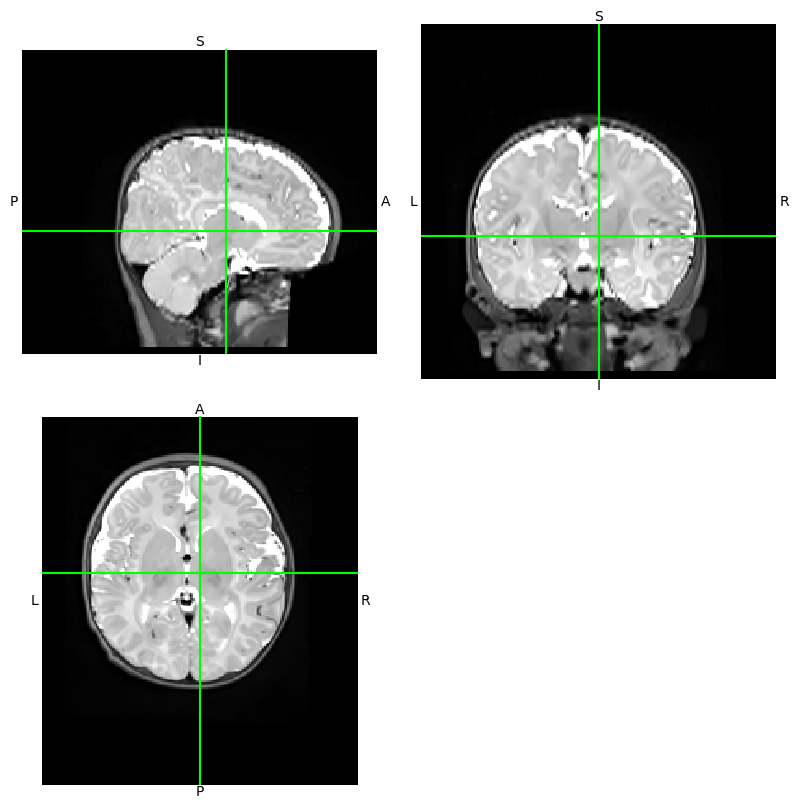

In [ ]:
#extract 3d patches
#choose patch size and stride as factor of image size
patch_size = (64, 64, 64)
stride = (32, 32, 32)
patches = extract_3D_patches(padded_lr_t2, patch_size, stride)
print(f"Extracted {len(patches)} patches of size {patch_size} from image of shape {padded_lr_t2.shape} with stride {stride}.")

#save one patch as nifti for visualization

patch_img = nib.Nifti1Image(patches[0], new_affine)
patch_img.orthoview()

#reconstruct image from patches
rec = reconstruct_from_patches(patches, padded_lr_t2.shape, stride)
rec_img = nib.Nifti1Image(rec, new_affine)
rec_img.orthoview()


<OrthoSlicer3D: (64, 64, 64)>

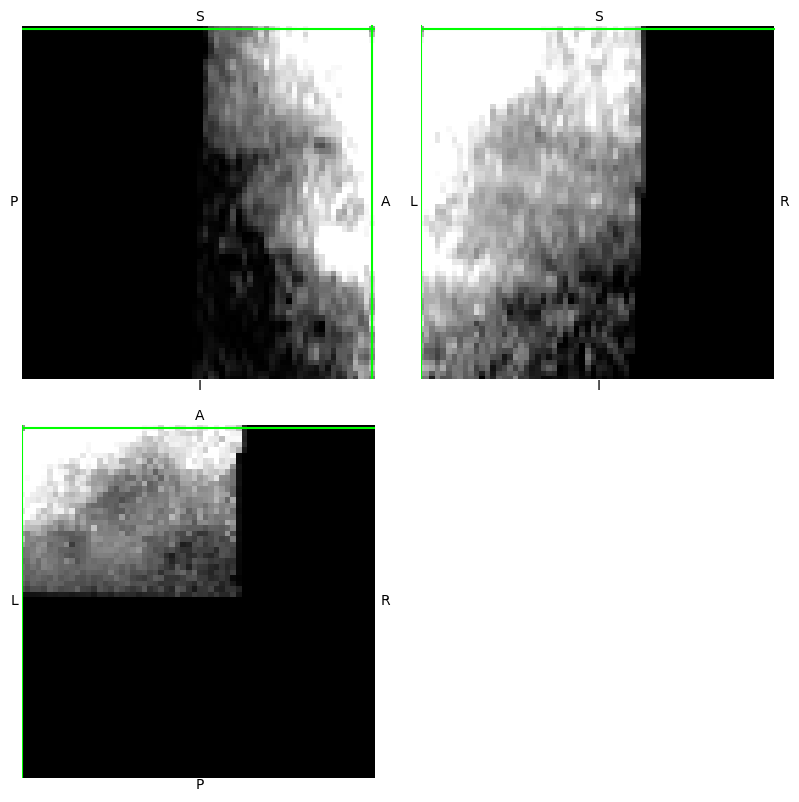

In [10]:
lr_t2_data[0:32, 0:32, 0:32]
nib.Nifti1Image(lr_t2_data[0:64, 0:64, 0:64], lr_t2.affine).orthoview()